# train

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(0)

In [7]:
dist = metrics.Gaussian(0, 1)
dist = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])

n_steps = 1000
svgd = SVGD(dist, n_steps)

In [18]:
h = 25
lr = 5
svgd_stepsize = 0.01
bandwidth = h

### train

In [19]:
x, log = svgd.train(rkey, h, lr, svgd_stepsize, n_steps)

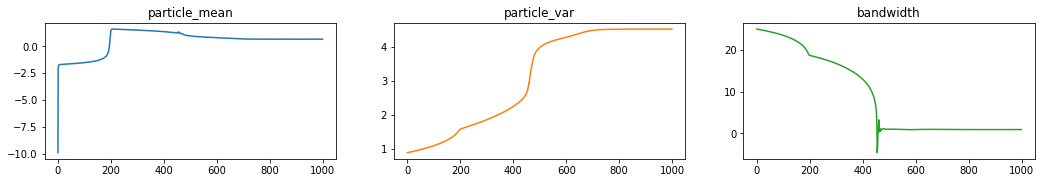

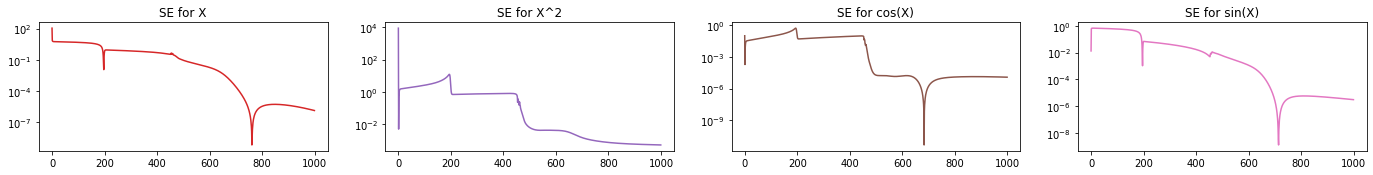

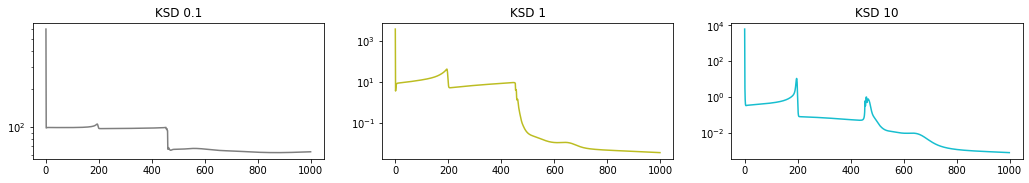

In [20]:
plot.svgd_log(log)

### histogram

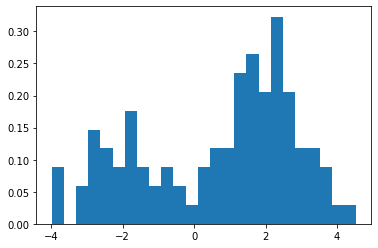

In [21]:
_ = plt.hist(x[:, 0], bins=25, density=True)

# compare sample

In [10]:
s = dist.sample(shape=(100,))

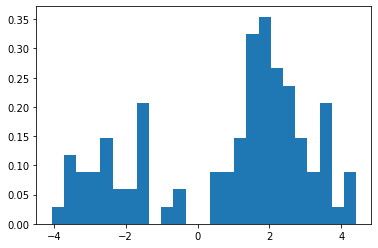

In [15]:
_ = plt.hist(s, bins=25, density=True)

In [19]:
s = s[:, np.newaxis]

In [20]:
dist.compute_metrics(s)

{'square_errors': DeviceArray([[0.03803014],
              [0.95213264],
              [0.0164856 ],
              [0.00256213]], dtype=float32),
 'ksds': DeviceArray([93.037674 ,  2.4144995,  0.42287  ], dtype=float32)}